DONE


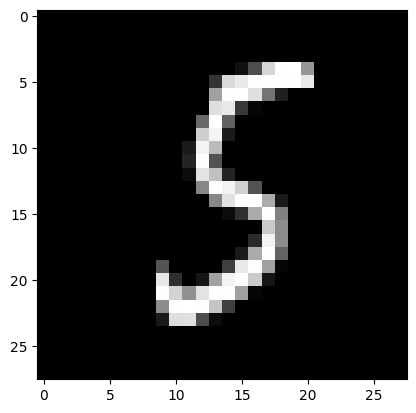

In [1]:
import torchvision.datasets as dts
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt
import random
%matplotlib inline

train_set = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_set = dts.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
print("DONE")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

image = random.choice(images)
plt.imshow(image.numpy().squeeze(), cmap='gray');

In [2]:
print(f"Shape: {image.shape}")

Shape: torch.Size([1, 28, 28])


In [3]:
import torch.nn as nn
import torch.nn.functional as F
class MNistModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [4]:
import torch.optim as optim
model = MNistModel(input_size=784, hidden_size=100, num_classes=10)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [5]:
from tqdm.notebook import tqdm
def train(
        model,
        train_loader,
        test_loader,
        loss_function,
        optimizer,
        epochs=100,
        ):
        epochs_count, train_losses, test_losses = [], [], []
        for epoch in tqdm(range(epochs+1)):
                model.train()
                for X, y in train_loader:
                        output = model(X)

                        train_loss = loss_function(output, y)
                        train_loss.backward()

                        optimizer.step()
                        optimizer.zero_grad()

                # TESTING
                test_loss = 0
                model.eval()
                for X, y in test_loader:
                        output = model(X)
                        test_loss = loss_function(output, y)
                if epoch % 10 == 0:
                        epochs_count.append(epoch)
                        train_losses.append(train_loss.detach().numpy())
                        test_losses.append(test_loss.detach().numpy())
                        print(f'Epoch {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
        return epochs_count, train_losses, test_losses

def accuracy(model, data_loader):
        from torchmetrics import Accuracy
        acc = Accuracy(task='multiclass', num_classes=10)
        model.eval()
        for X, y in data_loader:
                output = model(X)
                acc.update(output, y)
        return acc.compute()


In [6]:
epochs_count, train_losses, test_losses = train(model, train_loader, test_loader, loss_function, optimizer, epochs=10)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0, Train Loss: 2.12, Test Loss: 2.06
Epoch 10, Train Loss: 0.64, Test Loss: 0.40


In [7]:
print(f"Train Accuracy: {accuracy(model, train_loader):.2f}")
print(f"Test Accuracy: {accuracy(model, test_loader):.2f}")

Train Accuracy: 0.86
Test Accuracy: 0.87


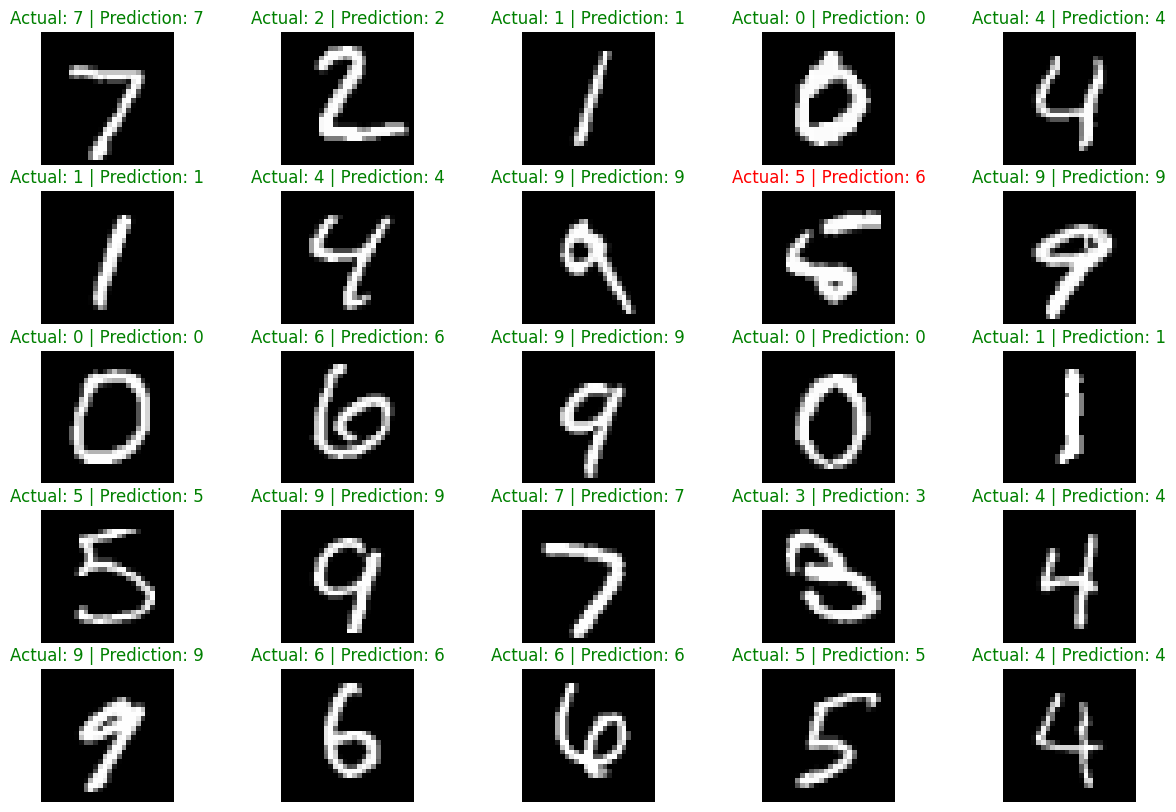

In [13]:
def predict(model, data):
    model.eval()
    with torch.inference_mode():
        output = model(data)
        predicted = torch.softmax(output, dim=1).argmax(dim=1)
        return predicted


images, labels = next(iter(test_loader))

plt.figure(figsize=(15, 10))
for i in range(25):
    image = images[i]
    label = labels[i]
    prediction = predict(model, image).item()
    color = 'green' if label == prediction else 'red'
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Actual: {label} | Prediction: {prediction}', color=color)
plt.show()
